In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.test import is_gpu_available
import json
import matplotlib.pyplot as plt
is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
DATASET_PATH = 'data.json'
def load_data(dataset_path):
    with open(dataset_path,'r') as file:
        data = json.load(file)
    inputs = np.array(data['mfccs'])
    targets = np.array(data['label'])
    genres = np.array(data['mappings'])
    return inputs,targets,genres
inputs,targets,genres = load_data(DATASET_PATH)

In [3]:
X_train,X_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.3,random_state=42)
print('training size: {}\ntest size: {}\n'.format(X_train.shape[0],X_test.shape[0]))

training size: 6990
test size: 2996



In [4]:
X_train[0].shape

(130, 13)

## Let's Try with a Simple ANN Model

In [5]:
model_simple = keras.Sequential([
    keras.layers.Flatten(input_shape = (inputs.shape[1],inputs.shape[2])),
    keras.layers.Dense(units = 512,activation = 'relu'),
    keras.layers.Dense(units = 256,activation = 'relu'),
    keras.layers.Dense(units = 64,activation = 'relu'),
    keras.layers.Dense(units = 10,activation = 'softmax')
])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_simple.compile(optimizer = optimizer,loss = 'sparse_categorical_crossentropy',metrics = 'accuracy')
model_simple.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [6]:
history_model_simple = model_simple.fit(X_train,y_train,
                    validation_data=(X_test,y_test),
                    epochs = 100,
                    batch_size = 32
                   )

Epoch 1/100
219/219 [==============================] - 2s 4ms/step - loss: 9.5293 - accuracy: 0.3143 - val_loss: 3.3686 - val_accuracy: 0.3311
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 2.2951 - accuracy: 0.3552 - val_loss: 2.1547 - val_accuracy: 0.3321
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 1.7824 - accuracy: 0.3987 - val_loss: 2.0238 - val_accuracy: 0.3508
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 1.6310 - accuracy: 0.4368 - val_loss: 2.0228 - val_accuracy: 0.3992
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 1.5194 - accuracy: 0.4684 - val_loss: 1.9188 - val_accuracy: 0.4095
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 1.4267 - accuracy: 0.4948 - val_loss: 1.9551 - val_accuracy: 0.4062
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 1.3252 - accuracy: 0.5286 - val_loss: 1.9109 - val_accuracy: 0.4322

Epoch 58/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9783 - val_loss: 2.8141 - val_accuracy: 0.5871
Epoch 59/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0890 - accuracy: 0.9700 - val_loss: 2.9795 - val_accuracy: 0.5638
Epoch 60/100
219/219 [==============================] - 1s 6ms/step - loss: 0.0974 - accuracy: 0.9685 - val_loss: 2.7933 - val_accuracy: 0.5998
Epoch 61/100
219/219 [==============================] - 1s 6ms/step - loss: 0.0825 - accuracy: 0.9731 - val_loss: 2.8959 - val_accuracy: 0.5694
Epoch 62/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1272 - accuracy: 0.9587 - val_loss: 2.8288 - val_accuracy: 0.5714
Epoch 63/100
219/219 [==============================] - 1s 6ms/step - loss: 0.1043 - accuracy: 0.9648 - val_loss: 2.7833 - val_accuracy: 0.5858
Epoch 64/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0508 - accuracy: 0.9850 - val_loss: 2.8953 - val_accuracy:

In [7]:
def plot_history(history):
    
    fig,axs = plt.subplots(2,figsize=(20,15))
    #accuracy subplot
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].legend(['Train Accuracy','Test Accuracy'],loc = 'lower right')
    axs[0].set_title("Accuracy Evaluation")
    
    #error subplot
    axs[1].plot(history.history['loss'],label = 'Train Error')
    axs[1].plot(history.history['val_loss'],label = 'Test Error')
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(['Train Error','Test Error'],loc = 'upper right')
    axs[1].set_title("Error Evaluation")
    plt.show()
    

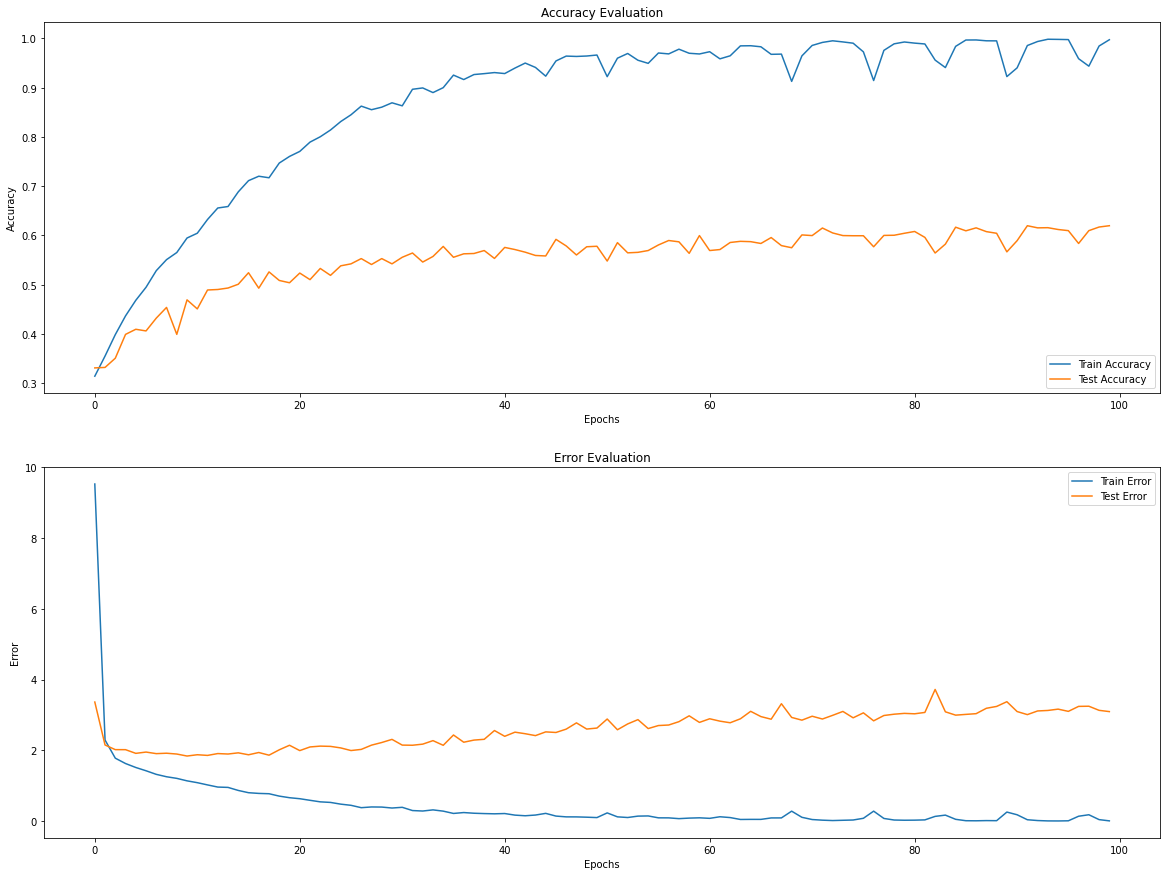

In [8]:
plot_history(history_model_simple)    

## Clearly the Simple Model is Overfitting

Approach to Solve Overfitting :-
- Adding Dropout Layer
- L2 Regularizing

In [9]:
model_dr_regularization = keras.Sequential([
    keras.layers.Flatten(input_shape = (inputs.shape[1],inputs.shape[2])),
    
    # 1st Dense Layer with Regularization and Dropout
    keras.layers.Dense(units = 512,activation = 'relu',kernel_regularizer = keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.3),
    
    # 2nd Dense Layer with Regularization and Dropout
    keras.layers.Dense(units = 256,activation = 'relu',kernel_regularizer = keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.3),
    
    # 3rd Dense Layer with Regularization and Dropout
    keras.layers.Dense(units = 64,activation = 'relu',kernel_regularizer = keras.regularizers.l2(0.0001)),
    keras.layers.Dropout(0.3),
    
    # Output Layer
    keras.layers.Dense(units = 10,activation = 'softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_dr_regularization.compile(optimizer = optimizer,loss = 'sparse_categorical_crossentropy',metrics = 'accuracy')
model_dr_regularization.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [10]:
history_model_dr_regularization = model_dr_regularization.fit(X_train,y_train,
                                          validation_data=(X_test,y_test),
                                          epochs = 100,
                                          batch_size = 32,
                                         ) 
                   

Epoch 1/100
219/219 [==============================] - 2s 6ms/step - loss: 22.2730 - accuracy: 0.1601 - val_loss: 2.5484 - val_accuracy: 0.2089
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 5.4818 - accuracy: 0.1675 - val_loss: 2.2975 - val_accuracy: 0.1826
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 3.3240 - accuracy: 0.1557 - val_loss: 2.3231 - val_accuracy: 0.1792
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 2.8300 - accuracy: 0.1448 - val_loss: 2.3298 - val_accuracy: 0.1822
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 2.6112 - accuracy: 0.1595 - val_loss: 2.3031 - val_accuracy: 0.1933
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 2.4958 - accuracy: 0.1717 - val_loss: 2.2742 - val_accuracy: 0.1993
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 2.4366 - accuracy: 0.1732 - val_loss: 2.2554 - val_accuracy: 0.204

Epoch 58/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5656 - accuracy: 0.4642 - val_loss: 1.6077 - val_accuracy: 0.4913
Epoch 59/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5356 - accuracy: 0.4652 - val_loss: 1.6355 - val_accuracy: 0.4883
Epoch 60/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5216 - accuracy: 0.4718 - val_loss: 1.6331 - val_accuracy: 0.4883
Epoch 61/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5299 - accuracy: 0.4747 - val_loss: 1.6281 - val_accuracy: 0.4927
Epoch 62/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5096 - accuracy: 0.4740 - val_loss: 1.6840 - val_accuracy: 0.4917
Epoch 63/100
219/219 [==============================] - 1s 5ms/step - loss: 1.5086 - accuracy: 0.4811 - val_loss: 1.5794 - val_accuracy: 0.4987
Epoch 64/100
219/219 [==============================] - 1s 5ms/step - loss: 1.4818 - accuracy: 0.4858 - val_loss: 1.6187 - val_accuracy:

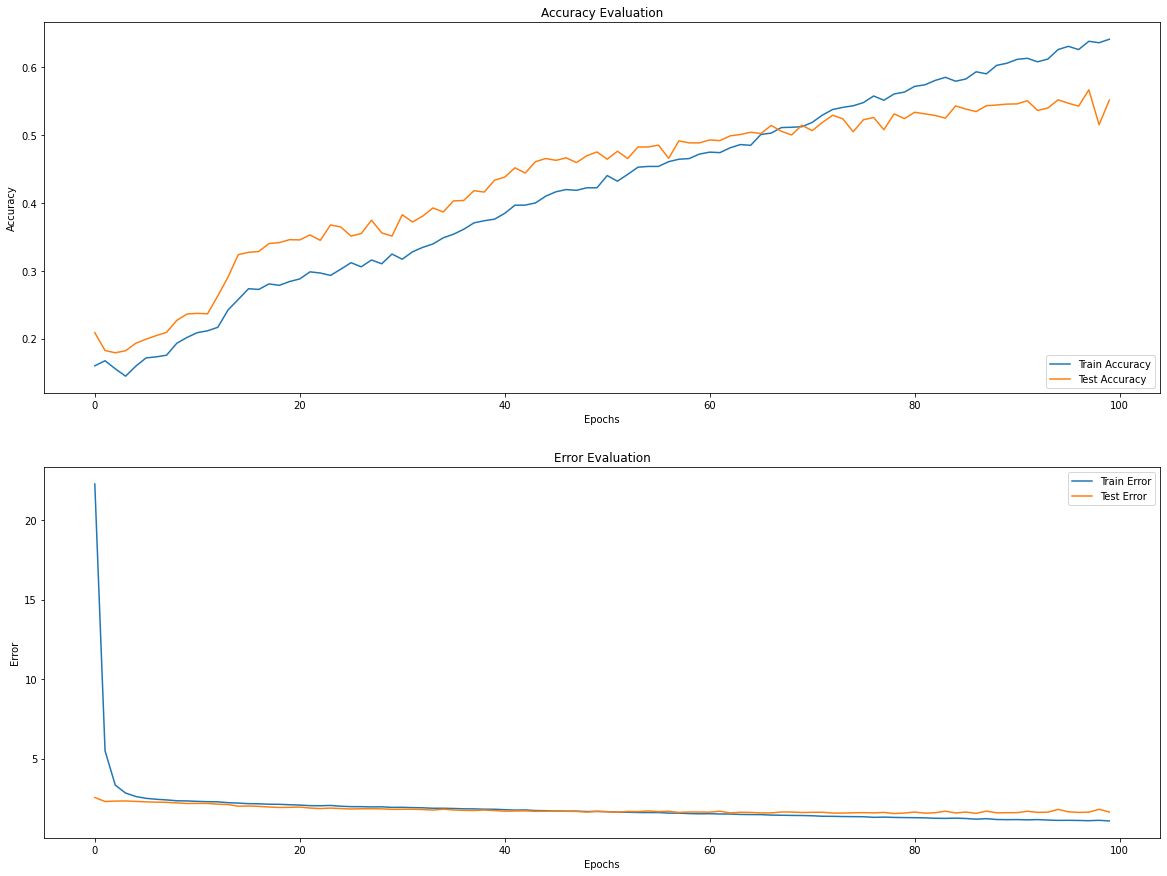

In [11]:
plot_history(history_model_dr_regularization)

In [33]:
test_error,test_accuracy = model_dr_regularization.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy is {} %".format(test_accuracy*100))

79/79 [==============================] - 0s 2ms/step - loss: 1.0513 - accuracy: 0.6800
Test Accuracy is 68.0016040802002 %


## Solved Overfitting but accuracy is not up to the mark
 #### Let's use another type of Neural Nets ie; CNNs
  
 But why use CNNs ?
 - Our spectrogram (here features/MFCCs) is similar to a GrayScale Image.
 - Faster Computation
 

In [12]:
def prepare_dataset(test_size,validation_size):
    
    inputs,targets,_ = load_data(dataset_path=DATASET_PATH)
    X_train,X_test,y_train,y_test = train_test_split(inputs,targets,test_size=test_size)
    X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=validation_size)
    # Adding a new axis because Conv2D expects 4D arrays the 4th dim being the number of channels here #channels = 1
    X_train = X_train[...,np.newaxis]
    X_validation = X_validation[...,np.newaxis]
    X_test = X_test[...,np.newaxis]
    return X_train,X_validation,X_test,y_train,y_validation,y_test
    

In [13]:
X_train_new,X_validation,X_test_new,y_train_new,y_validation,y_test_new = prepare_dataset(0.25,0.2)
print(X_train_new.shape)

(5991, 130, 13, 1)


In [14]:
def build_model_cnn(input_shape):
    
    model = keras.Sequential()
    
    # 1st Conv2d Layer with MaxPooling and Batch Normalization Layer
    model.add(keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
    model.add(keras.layers.MaxPool2D(pool_size = (3,3),strides = (2,2),padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd Conv2d Layer with MaxPooling and Batch Normalization Layer
    model.add(keras.layers.Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
    model.add(keras.layers.MaxPool2D(pool_size = (3,3),strides = (2,2),padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd Conv2d Layer with MaxPooling and Batch Normalization Layer
    model.add(keras.layers.Conv2D(32,(2,2),activation = 'relu',input_shape = input_shape))
    model.add(keras.layers.MaxPool2D(pool_size = (2,2),strides = (2,2),padding = 'same'))
    model.add(keras.layers.BatchNormalization())
    
    # To Flatten the the features
    model.add(keras.layers.Flatten())
    
    # Fully Connected Layers with Dropout 
    model.add(keras.layers.Dense(64,activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Output Layer
    model.add(keras.layers.Dense(10,activation = 'softmax'))
    
    return model

In [15]:
input_shape = (X_train_new.shape[1],X_train_new.shape[2],X_train_new.shape[3])    
cnn_model = build_model_cnn(input_shape)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer = optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 1, 32)        

In [16]:
cnn_history = cnn_model.fit(X_train_new,y_train_new,
                           validation_data=(X_validation,y_validation),
                           epochs = 100,
                           batch_size = 32)

Epoch 1/100
188/188 [==============================] - 7s 10ms/step - loss: 2.3557 - accuracy: 0.2260 - val_loss: 1.8401 - val_accuracy: 0.3244
Epoch 2/100
188/188 [==============================] - 1s 7ms/step - loss: 1.8357 - accuracy: 0.3602 - val_loss: 1.5369 - val_accuracy: 0.4399
Epoch 3/100
188/188 [==============================] - 1s 8ms/step - loss: 1.6242 - accuracy: 0.4206 - val_loss: 1.4026 - val_accuracy: 0.5053
Epoch 4/100
188/188 [==============================] - 1s 7ms/step - loss: 1.5190 - accuracy: 0.4572 - val_loss: 1.3262 - val_accuracy: 0.5200
Epoch 5/100
188/188 [==============================] - 1s 8ms/step - loss: 1.4347 - accuracy: 0.4841 - val_loss: 1.2716 - val_accuracy: 0.5327
Epoch 6/100
188/188 [==============================] - 1s 7ms/step - loss: 1.3481 - accuracy: 0.5096 - val_loss: 1.2543 - val_accuracy: 0.5607
Epoch 7/100
188/188 [==============================] - 1s 7ms/step - loss: 1.2980 - accuracy: 0.5401 - val_loss: 1.1741 - val_accuracy: 0.581

188/188 [==============================] - 4s 19ms/step - loss: 0.4352 - accuracy: 0.8506 - val_loss: 0.8122 - val_accuracy: 0.7256
Epoch 58/100
188/188 [==============================] - 3s 18ms/step - loss: 0.4386 - accuracy: 0.8459 - val_loss: 0.8268 - val_accuracy: 0.7236
Epoch 59/100
188/188 [==============================] - 3s 18ms/step - loss: 0.4257 - accuracy: 0.8553 - val_loss: 0.7998 - val_accuracy: 0.7383
Epoch 60/100
188/188 [==============================] - 6s 33ms/step - loss: 0.4161 - accuracy: 0.8556 - val_loss: 0.7906 - val_accuracy: 0.7457
Epoch 61/100
188/188 [==============================] - 7s 36ms/step - loss: 0.4248 - accuracy: 0.8539 - val_loss: 0.8178 - val_accuracy: 0.7270
Epoch 62/100
188/188 [==============================] - 7s 35ms/step - loss: 0.4173 - accuracy: 0.8578 - val_loss: 0.8485 - val_accuracy: 0.7190
Epoch 63/100
188/188 [==============================] - 7s 35ms/step - loss: 0.3995 - accuracy: 0.8611 - val_loss: 0.8127 - val_accuracy: 0.745

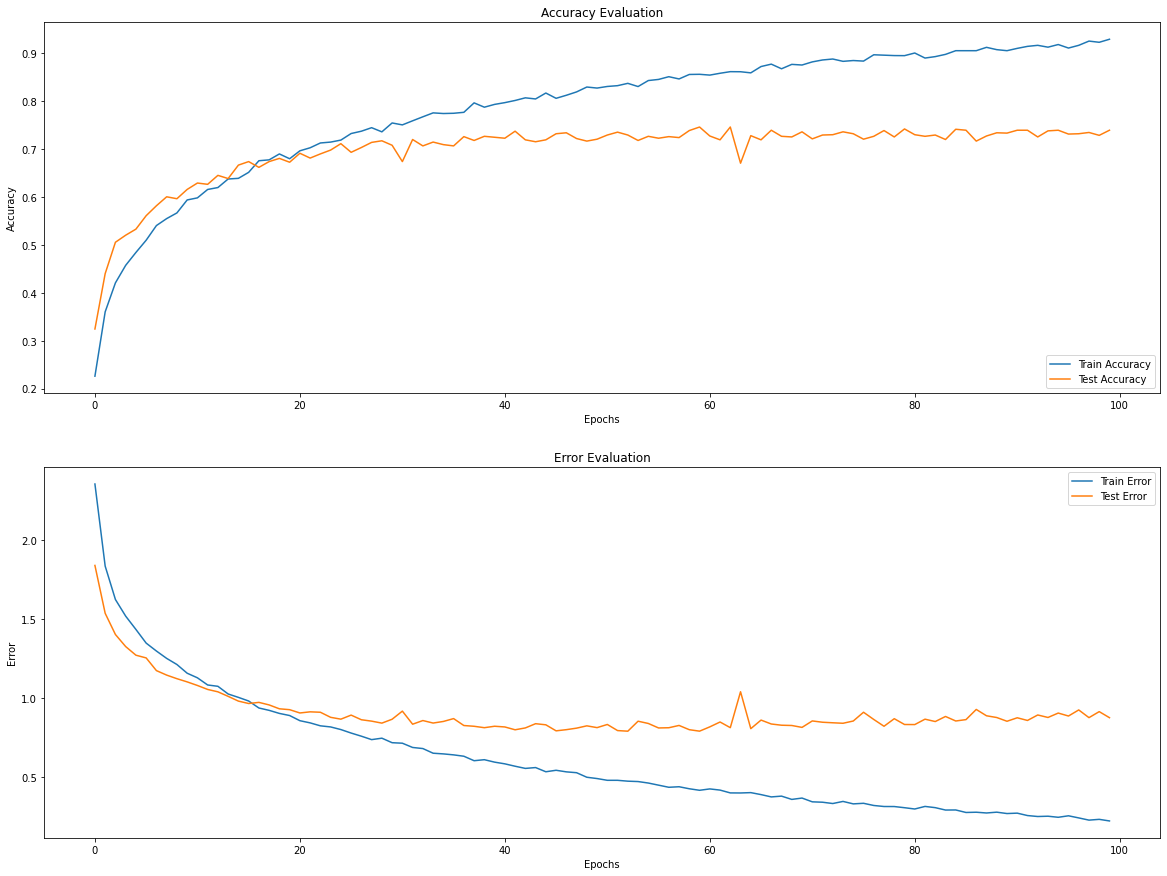

In [17]:
plot_history(cnn_history)

In [18]:
test_error,test_accuracy = cnn_model.evaluate(X_test_new,y_test_new,verbose = 1)
print("Test Accuracy is {:.4} %".format(test_accuracy*100))

79/79 [==============================] - 1s 17ms/step - loss: 0.8715 - accuracy: 0.7397
Test Accuracy is 73.97 %


In [19]:
def predict(X,y,model):
    y = genres[y]
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction,axis=1)
    predicted_genre = genres[predicted_index]
    print("Predicted Genre: {}\nExpected Genre: {}".format(predicted_genre[0],y))
    
X,y = X_test_new[645],y_test_new[645]
predict(X,y,cnn_model)

Predicted Genre: classical
Expected Genre: classical


## Nice we achieved an accuracy of 73.97% on test set which is not bad
#### But let's not forget that audio is a time-series so we try LSTMs which is well suited for time-related data and see if we can get any better results from this

In [20]:
def prepare_dataset_lstm(test_size,validation_size):
    
    inputs,targets,_ = load_data(dataset_path=DATASET_PATH)
    X_train,X_test,y_train,y_test = train_test_split(inputs,targets,test_size=test_size)
    X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=validation_size)
    # here we don't require 4th dims as here lstm take input shape as (#Samples,#Steps,#features)
    return X_train,X_validation,X_test,y_train,y_validation,y_test
    

In [21]:
def build_model_lstm(input_shape):
    model = keras.Sequential()
    
    # 1st LSTM layer 
    # Note that here we return the sequences because the next LSTM layer is expecting sequence of data and not a vector
    model.add(keras.layers.LSTM(64,input_shape = input_shape,return_sequences = True))
    model.add(keras.layers.LSTM(64))
    
    # 2nd LSTM layer
    model.add(keras.layers.Dense(64,activation = 'relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # Output Layer
    model.add(keras.layers.Dense(10,activation = 'softmax'))
    
    return model    

In [22]:
X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_dataset_lstm(0.25,0.2)
input_shape_lstm = (X_train.shape[1],X_train.shape[2])
lstm_model = build_model_lstm(input_shape_lstm)

In [23]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = 'accuracy')
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 130, 64)           19968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________


In [24]:
lstm_history = lstm_model.fit(X_train,y_train,
                              validation_data = (X_validation,y_validation),
                             epochs = 100,
                             batch_size = 32)

Epoch 1/100
188/188 [==============================] - 7s 25ms/step - loss: 2.1834 - accuracy: 0.2098 - val_loss: 2.0337 - val_accuracy: 0.3011
Epoch 2/100
188/188 [==============================] - 5s 24ms/step - loss: 1.9391 - accuracy: 0.3190 - val_loss: 1.7949 - val_accuracy: 0.3658s - l
Epoch 3/100
188/188 [==============================] - 4s 22ms/step - loss: 1.7805 - accuracy: 0.3592 - val_loss: 1.6607 - val_accuracy: 0.4252
Epoch 4/100
188/188 [==============================] - 4s 22ms/step - loss: 1.6654 - accuracy: 0.4103 - val_loss: 1.5964 - val_accuracy: 0.4473
Epoch 5/100
188/188 [==============================] - 4s 22ms/step - loss: 1.6022 - accuracy: 0.4226 - val_loss: 1.5289 - val_accuracy: 0.4673
Epoch 6/100
188/188 [==============================] - 4s 22ms/step - loss: 1.5251 - accuracy: 0.4585 - val_loss: 1.4605 - val_accuracy: 0.4967
Epoch 7/100
188/188 [==============================] - 4s 22ms/step - loss: 1.4745 - accuracy: 0.4847 - val_loss: 1.4223 - val_accu

188/188 [==============================] - 5s 26ms/step - loss: 0.7039 - accuracy: 0.7702 - val_loss: 1.0586 - val_accuracy: 0.6689ss: 0.7038 - accuracy: 0.77
Epoch 58/100
188/188 [==============================] - 5s 27ms/step - loss: 0.7019 - accuracy: 0.7732 - val_loss: 1.0302 - val_accuracy: 0.6762
Epoch 59/100
188/188 [==============================] - 5s 26ms/step - loss: 0.7056 - accuracy: 0.7750 - val_loss: 1.0540 - val_accuracy: 0.6595
Epoch 60/100
188/188 [==============================] - 5s 27ms/step - loss: 0.6999 - accuracy: 0.7767 - val_loss: 1.0794 - val_accuracy: 0.6656
Epoch 61/100
188/188 [==============================] - 5s 27ms/step - loss: 0.6784 - accuracy: 0.7838 - val_loss: 1.0556 - val_accuracy: 0.6615
Epoch 62/100
188/188 [==============================] - 5s 26ms/step - loss: 0.6925 - accuracy: 0.7807 - val_loss: 1.0494 - val_accuracy: 0.6789
Epoch 63/100
188/188 [==============================] - 6s 31ms/step - loss: 0.6830 - accuracy: 0.7877 - val_loss: 1

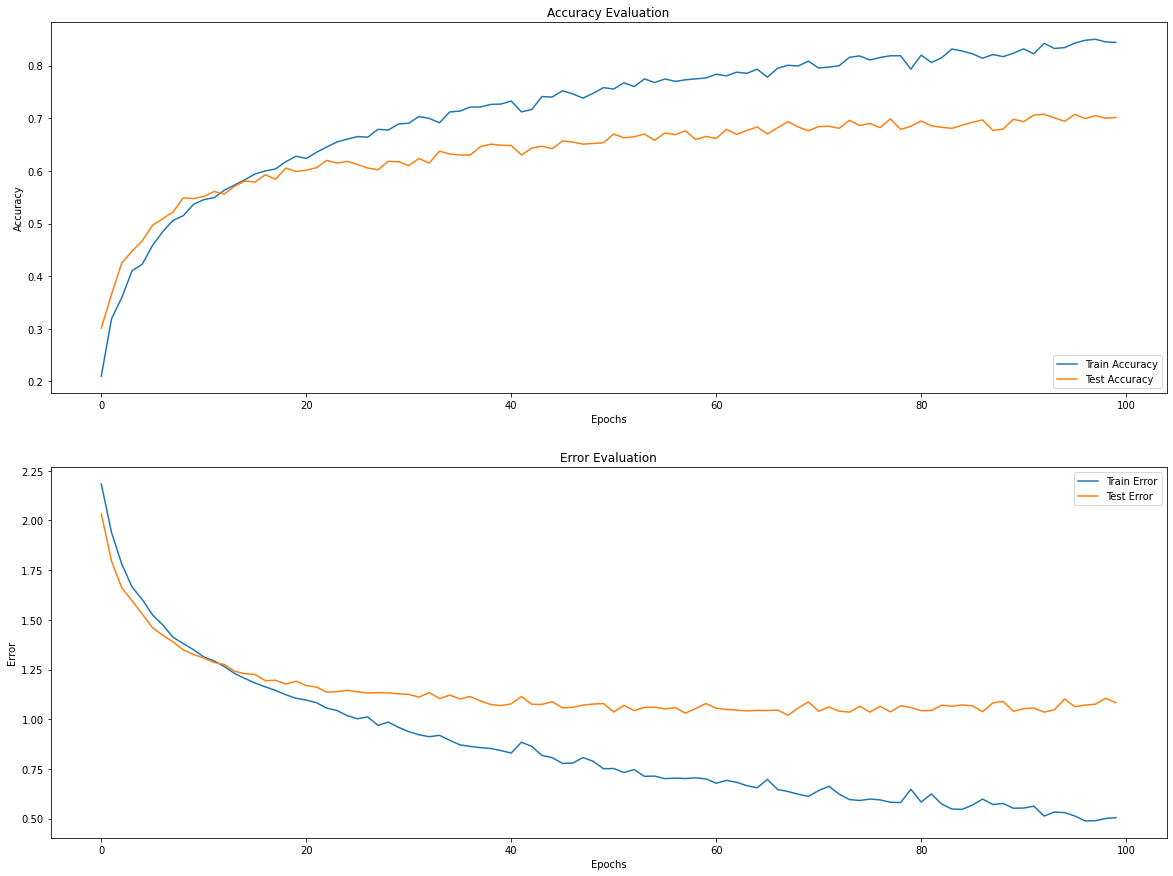

In [25]:
plot_history(lstm_history)

In [26]:
test_error,test_accuracy = lstm_model.evaluate(X_test,y_test,verbose = 1)
print("Test Accuracy is {:.4} %".format(test_accuracy*100))

79/79 [==============================] - 1s 11ms/step - loss: 1.1520 - accuracy: 0.6660
Test Accuracy is 66.6 %


In [27]:
def predict_lstm(X,y,model):
    y = genres[y]
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction,axis=1)
    predicted_genre = genres[predicted_index]
    print("Predicted Genre: {}\nExpected Genre: {}".format(predicted_genre[0],y))
X,y = X_test[645],y_test[645]
predict_lstm(X,y,lstm_model)

Predicted Genre: rock
Expected Genre: rock


## We can see that here LSTM is not giving higher accuracy on test data so we can conclude that CNNs give better accuracy out of the 4 models made.